# DnD Monster Data Wrangling


## Importation

In [495]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.data import make_dataset

ModuleNotFoundError: No module named 'src'

In [5]:
from math import pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
from bioinfokit.analys import stat
from src.data.build_features import clean_list


%matplotlib inline

monster_df = pd.read_csv('../data/raw/Monster_Data_RAW.csv')

monster_df.head()

,Unnamed: 0,Monster Name,Size,Type,Alignment,Traits,Damage Resistances,Monster Tags:,Mythic Actions,Reactions,...,Proficiency Bonus,STR,DEX,CON,INT,WIS,CHA,Actions,Legendary Actions,Environment:
0,0,Adult Green Dragon,Huge,['dragon'],lawful evil,['Amphibious. The dragon can breathe air and w...,NaN,NaN,NaN,NaN,...,5,23,12,21,18,15,17,['Multiattack. The dragon can use its Frightfu...,"[""The dragon can take 3 legendary actions, cho...",['Forest']
1,1,Adult Silver Dragon,Huge,['dragon'],lawful good,['Legendary Resistance (3/Day). If the dragon ...,NaN,NaN,NaN,NaN,...,5,27,10,25,16,13,21,['Multiattack. The dragon can use its Frightfu...,"[""The dragon can take 3 legendary actions, cho...","['Mountain', 'Urban']"
2,2,Adult White Dragon,Huge,['dragon'],chaotic evil,"[""Ice Walk. The dragon can move across and cli...",NaN,NaN,NaN,NaN,...,5,22,10,22,8,12,12,['Multiattack. The dragon can use its Frightfu...,"[""The dragon can take 3 legendary actions, cho...",['Arctic']
3,3,Air Elemental,Large,['elemental'],neutral,"[""Air Form. The elemental can enter a hostile ...","Lightning, Thunder; Bludgeoning, Piercing, and...",NaN,NaN,NaN,...,3,14,20,14,6,10,6,['Multiattack. The elemental makes two slam at...,NaN,"['Desert', 'Mountain']"
4,4,Ape,Medium,['beast'],unaligned,[nan],NaN,['Misc Creature'],NaN,NaN,...,2,16,14,14,6,12,7,['Multiattack. The ape makes two fist attacks....,NaN,['Forest']


'..'

## Performing the Basic Cleanup
Removing columns we won't use, cleanining up feature titles, and checking out our dataset for datatypes and issues.

We know that Mythic Actions weren't introducted until a later version, so no monsters contain this category.

Unnamed:0 is useless, Monster Tags: is the same as Monster type (with a bit more specificity, which we don't need.)

Skills, Source, Launguages, and Senses are all unecessary for our MVP.

In [427]:
monster_df.drop(columns = {'Unnamed: 0', 'Mythic Actions', 'Monster Tags:', "Skills", 'Source', 'Languages', "Senses"}, inplace = True, axis = 1)
monster_df.rename(columns = {"Environment:":"Environment"}, inplace=True)

In [428]:
print(monster_df.columns)
print(monster_df.describe())

Index(['Monster Name', 'Size', 'Type', 'Alignment', 'Traits',
       'Damage Resistances', 'Reactions', 'Armor Class', 'Hit Points', 'Speed',
       'Saving Throws', 'Damage Vulnerabilities', 'Damage Immunities',
       'Condition Immunities', 'Challenge', 'Proficiency Bonus', 'STR', 'DEX',
       'CON', 'INT', 'WIS', 'CHA', 'Actions', 'Legendary Actions',
       'Environment', 'Attack_Bonus', 'Spell_Bonus', 'Spell_Save_DC'],
      dtype='object')
       Armor Class  Hit Points   Challenge  Proficiency Bonus         STR  \
count   348.000000  348.000000  348.000000         348.000000  348.000000   
mean     13.985632   78.399425    4.346624           2.712644   14.951149   
std       3.155403   96.670352    5.711322           1.296486    6.705018   
min       5.000000    1.000000    0.000000           2.000000    1.000000   
25%      12.000000   17.000000    0.250000           2.000000   11.000000   
50%      13.000000   45.000000    2.000000           2.000000   16.000000   
75%      

## Challenge Rating (CR)
Currently Challenge Rating is a string, we want it to be an integer so we can use it. We need to remove the experience string attached and convert.

In [424]:
#split the string and only take the first part (Challenge Rating)
monster_df["Challenge"] = monster_df["Challenge"].str.split().str[0]

#turn fraction strings into floats
for indx, challenge in enumerate(monster_df["Challenge"]):
    if "/" in challenge:
       monster_df.loc[indx,'Challenge'] = pd.eval(challenge)
    else:
        monster_df.loc[indx,'Challenge'] = pd.to_numeric(challenge)

monster_df["Challenge"] = pd.to_numeric(monster_df["Challenge"])

## Monster Type
There are a large number of monster sub-types, this is unecessary for our analysis. we want to consolidate. 

In [429]:
for indx,Type in enumerate(monster_df['Type']):
    monster_df.loc[indx,"Type"] = Type.split(",")[0].strip("[']")

## Missing Values

All features with missing values make sense esxcept Actions, which I would have assumed every creature has an action, that may not be the case however. For the others, they are all optional features that lower level monsters won't have.

The NAs may still cause issues down the road, so I will replace them all with a string text like "NA"

In [436]:
monster_df[monster_df.isna().any()].tolist()

['Damage Resistances',
 'Reactions',
 'Saving Throws',
 'Damage Vulnerabilities',
 'Damage Immunities',
 'Condition Immunities',
 'Actions',
 'Legendary Actions',
 'Environment']

In [ ]:
monster_df["Environment"].fillna("None",inplace=True)


## List Values
We current have features where the values are varying list of items. For example, a monster may be found in more than one environment such as [mountain, coastal, underdark]. Unfortuntaly, they are reading as strings right now so we will need to convert them to lists for easy of use.

In [ ]:
#All lists columns are actually strings!
for i,j in enumerate(monster_df["Environment"]):
   print("list",i,"is",type(j))

### Attack, Spell Attack, Save DC
Actually, there is some information within these strings we can pull out easily with regex search, match, findall. Let's do that before converting into lists

In [425]:
# Create new columns for features
monster_df = monster_df.assign(Attack_Bonus= '', Spell_Bonus = '', Spell_Save_DC = '')

#Attack Bonus
for indx, action in enumerate(monster_df['Actions']):
    try:
        found = re.search("\+(.+?) to hit", action).group(0)
        monster_df.loc[indx,'Attack_Bonus'] = int(found.split()[0].lstrip('+'))
    except:
        monster_df.loc[indx,'Attack_Bonus'] = 0

#Spell Attack Bonus

for indx, trait in enumerate(monster_df['Traits']):
    try:
        found = re.search("\+(.+?) to hit", trait).group(0)
        monster_df.loc[indx,'Spell_Bonus'] = int(found.split()[0].lstrip('+'))
    except:
        monster_df.loc[indx,'Spell_Bonus'] = 0

#Spell Save DC

for indx, trait in enumerate(monster_df['Traits']):
    try:
        found = re.search("spell save DC [0-9]+", trait).group(0)
        monster_df.loc[indx,'Spell_Save_DC'] = int(found.split()[-1])
    except:
        monster_df.loc[indx,'Spell_Save_DC'] = 0

In [ ]:

monster_df["Saving Throws"] = monster_df['Saving Throws'].apply(clean_list)

#evaluate string and turn into lists
column_lists = ["Environment", "Reactions", "Actions", "Legendary Actions", "Saving Throws"]
for columns in column_lists:
    monster_df[columns].fillna("None",inplace=True)
    monster_df[columns] = monster_df[columns].apply(ast.literal_eval)

#Saving Throw Exapand
saving_throw_df = pd.DataFrame(columns={"STR_SV","DEX_SV","CON_SV","INT_SV","WIS_SV","CHA_SV"})

for indx, saving_throw in enumerate(monster_df['Saving Throws']): 
    for string in saving_throw:
        if "DEX" in string:
            saving_throw_df.loc[indx,"DEX_SV"] = int(string.split()[1].lstrip('+'))
        elif "CON" in string:
            saving_throw_df.loc[indx,"CON_SV"] = int(string.split()[1].lstrip('+'))
        elif "STR" in string:
            saving_throw_df.loc[indx,"STR_SV"] = int(string.split()[1].lstrip('+'))
        elif "WIS" in string:
            saving_throw_df.loc[indx,"WIS_SV"] = int(string.split()[1].lstrip('+'))
        elif "INT" in string:
            saving_throw_df.loc[indx,"INT_SV"] = int(string.split()[1].lstrip('+'))
        elif "CHA" in string:
            saving_throw_df.loc[indx,"CHA_SV"] = int(string.split()[1].lstrip('+'))
            
monster_df = pd.concat([monster_df,saving_throw_df], axis=1)

#"Damage Resistances","Damage Vulnerabilities", "Damage Immunities", have wonky typing due to semicolon
# Traits, Condition immunities, saving throws create type error

#check that they are lists
for i,j in enumerate(monster_df["Environment"]):
   print("list",i,"is",type(j))

#create dummy variables for envinroment, which includes the list for variables
dummies = pd.get_dummies(monster_df['Environment'].explode()).reset_index().groupby(['index']).sum()
monster_df = pd.concat([monster_df,dummies], axis=1)

In [409]:
monster_df["Saving Throws"]

0       DEX +6, CON +10, WIS +7, CHA +8
1      DEX +5, CON +12, WIS +6, CHA +10
2       DEX +5, CON +11, WIS +6, CHA +6
3                                   NaN
4                                   NaN
                     ...               
343                                 NaN
344                              WIS +0
345                                 NaN
346                                 NaN
347      STR +9, CON +9, WIS +7, CHA +7
Name: Saving Throws, Length: 348, dtype: object

In [396]:
monster_df

,Monster Name,Size,Type,Alignment,Traits,Damage Resistances,Reactions,Armor Class,Hit Points,Speed,...,Swamp,Underdark,Underwater,Urban,WIS_SV,CON_SV,CHA_SV,INT_SV,DEX_SV,STR_SV
0,Adult Green Dragon,Huge,dragon,lawful evil,['Amphibious. The dragon can breathe air and w...,NaN,None,19,207,"40 ft., fly 80 ft., swim 40 ft.",...,0,0,0,0,WIS +7,CON +10,CHA +8,NaN,DEX +6,NaN
1,Adult Silver Dragon,Huge,dragon,lawful good,['Legendary Resistance (3/Day). If the dragon ...,NaN,None,19,243,"40 ft., fly 80 ft.",...,0,0,0,1,WIS +6,CON +12,CHA +10,NaN,DEX +5,NaN
2,Adult White Dragon,Huge,dragon,chaotic evil,"[""Ice Walk. The dragon can move across and cli...",NaN,None,18,200,"40 ft., burrow 30 ft., fly 80 ft., swim 40 ft.",...,0,0,0,0,WIS +6,CON +11,CHA +6,NaN,DEX +5,NaN
3,Air Elemental,Large,elemental,neutral,"[""Air Form. The elemental can enter a hostile ...","Lightning, Thunder; Bludgeoning, Piercing, and...",None,15,90,"0 ft., fly 90 ft. (hover)",...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Ape,Medium,beast,unaligned,[nan],NaN,None,12,19,"30 ft., climb 30 ft.",...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,Wyvern,Large,dragon,unaligned,[nan],NaN,None,13,110,"20 ft., fly 80 ft.",...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
344,Zombie,Medium,undead,neutral evil,['Undead Fortitude. If damage reduces the zomb...,NaN,None,8,22,20 ft.,...,0,0,0,1,WIS +0,NaN,NaN,NaN,NaN,NaN
345,Commoner,Medium,humanoid,any alignment,[nan],NaN,None,10,4,30 ft.,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
346,Giant Owl,Large,beast,neutral,"[""Flyby. The owl doesn't provoke opportunity a...",NaN,None,12,19,"5 ft., fly 60 ft.",...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


[Text(0, 0, '2'),
 Text(1, 0, '3'),
 Text(2, 0, '4'),
 Text(3, 0, '5'),
 Text(4, 0, '6'),
 Text(5, 0, '7'),
 Text(6, 0, '9')]

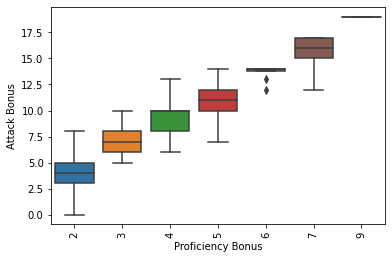

In [223]:
ax = sns.boxplot(x="Proficiency Bonus", y= "Attack Bonus", data=monster_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [60]:
monster_df['Actions'].explode().values

array(['Multiattack. The dragon can use its Frightful Presence. It then makes three attacks: one with its bite and two with its claws.',
       'Bite. Melee Weapon Attack: +11 to hit, reach 10 ft., one target. Hit: 17 (2d10 + 6) piercing damage plus 7 (2d6) poison damage.',
       'Claw. Melee Weapon Attack: +11 to hit, reach 5 ft., one target. Hit: 13 (2d6 + 6) slashing damage.',
       'Tail. Melee Weapon Attack: +11 to hit, reach 15 ft., one target. Hit: 15 (2d8 + 6) bludgeoning damage.',
       "Frightful Presence. Each creature of the dragon's choice that is within 120 feet of the dragon and aware of it must succeed on a DC 16 Wisdom saving throw or become frightened for 1 minute. A creature can repeat the saving throw at the end of each of its turns, ending the effect on itself on a success. If a creature's saving throw is successful or the effect ends for it, the creature is immune to the dragon's Frightful Presence for the next 24 hours.",
       'Poison Breath (Recharge 5–6). 

In [ ]:
# Reactions
#create dummy variables for envinroment, which includes the list for variables
dummies = pd.get_dummies(monster_df['Environment'].explode(),dummy_na=True).reset_index().groupby(['index']).sum()
monster_df = pd.concat([monster_df,dummies], axis=1)

list

In [169]:
# 123 Legendary Actions
# 17 Reactions
# 967 Actions

monster_df['Attack Bonus']

0       
1       
2       
3       
4       
      ..
343     
344     
345     
346     
347     
Name: Attack Bonus, Length: 348, dtype: object

In [ ]:
ax = sns.boxplot(x="Environment", y= "Hit Points",data=monster_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)